In [1]:
import pandas as pd
import pyomo.environ as pyo
from cronian.results import extract_prosumer_dispatch
from pyprojroot import here

from annular.satellite_model import MultiProfileBiddingStrategy

In [2]:
load_gen_ts = pd.read_csv(
    here("tests/data/multi_profile/loads_generators_timeseries.csv"),
    index_col=0,
    parse_dates=True,
)
forecast = pd.read_csv(here("tests/data/multi_profile/forecast-prices.csv"), index_col=0, parse_dates=True)
carrier_prices = pd.read_csv(here("tests/data/multi_profile/price_other_carriers.csv"), index_col=0, parse_dates=True)

In [3]:
strategy = MultiProfileBiddingStrategy(
    demands=load_gen_ts,
    ceiling_price=200,
    electricity_price_forecast=forecast,
    carrier_prices=carrier_prices,
    floor_price=0,
    horizon_size=48,
    cronian_config_path=here("tests/data/multi_profile/prosumers/P01.yaml"),
    output_path=here(),
)

In [4]:
forecast_scenarios = strategy.make_forecast_scenarios(strategy.base_forecast[:24], strategy.forecast_scaling_factor)

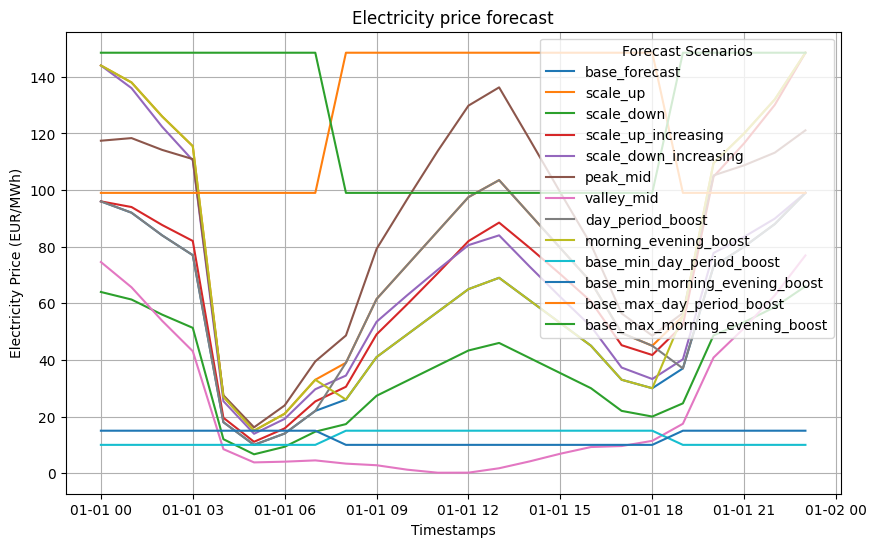

In [5]:
strategy.plot_forecast_scenarios(forecast_scenarios, here())

In [6]:
profiles = strategy._determine_profiles(forecast_scenarios)

In [7]:
horizon = strategy._get_horizon()

In [8]:
horizon

DatetimeIndex(['2024-01-01 00:00:00', '2024-01-01 01:00:00',
               '2024-01-01 02:00:00', '2024-01-01 03:00:00',
               '2024-01-01 04:00:00', '2024-01-01 05:00:00',
               '2024-01-01 06:00:00', '2024-01-01 07:00:00',
               '2024-01-01 08:00:00', '2024-01-01 09:00:00',
               '2024-01-01 10:00:00', '2024-01-01 11:00:00',
               '2024-01-01 12:00:00', '2024-01-01 13:00:00',
               '2024-01-01 14:00:00', '2024-01-01 15:00:00',
               '2024-01-01 16:00:00', '2024-01-01 17:00:00',
               '2024-01-01 18:00:00', '2024-01-01 19:00:00',
               '2024-01-01 20:00:00', '2024-01-01 21:00:00',
               '2024-01-01 22:00:00', '2024-01-01 23:00:00',
               '2024-01-02 00:00:00', '2024-01-02 01:00:00',
               '2024-01-02 02:00:00', '2024-01-02 03:00:00',
               '2024-01-02 04:00:00', '2024-01-02 05:00:00',
               '2024-01-02 06:00:00', '2024-01-02 07:00:00',
               '2024-01-

In [9]:
forecast_df = strategy.base_forecast.loc[horizon].copy()
forecast_df

e_price
snapshot                    
2024-01-01 00:00:00       96
2024-01-01 01:00:00       92
2024-01-01 02:00:00       84
2024-01-01 03:00:00       77
2024-01-01 04:00:00       18
2024-01-01 05:00:00       10
2024-01-01 06:00:00       14
2024-01-01 07:00:00       22
2024-01-01 08:00:00       26
2024-01-01 09:00:00       41
2024-01-01 10:00:00       49
2024-01-01 11:00:00       57
2024-01-01 12:00:00       65
2024-01-01 13:00:00       69
2024-01-01 14:00:00       61
2024-01-01 15:00:00       53
2024-01-01 16:00:00       45
2024-01-01 17:00:00       33
2024-01-01 18:00:00       30
2024-01-01 19:00:00       37
2024-01-01 20:00:00       73
2024-01-01 21:00:00       80
2024-01-01 22:00:00       88
2024-01-01 23:00:00       99
2024-01-02 00:00:00       96
2024-01-02 01:00:00       92
2024-01-02 02:00:00       84
2024-01-02 03:00:00       77
2024-01-02 04:00:00       18
2024-01-02 05:00:00       10
2024-01-02 06:00:00       14
2024-01-02 07:00:00       22
2024-01-02 08:00:00       26
2024-01-02 09:00:00       41
2024-01-02 10:00:00       49
2024-01-02 11:00:00       57
2024-01-02 12:00:00       65
2024-01-02 13:00:00       69
2024-01-02 14:00:00       61
2024-01-02 15:00:00       53
2024-01-02 16:00:00       45
2024-01-02 17:00:00       33
2024-01-02 18:00:00       30
2024-01-02 19:00:00       37
2024-01-02 20:00:00       73
2024-01-02 21:00:00       80
2024-01-02 22:00:00       88
2024-01-02 23:00:00       99

In [10]:
profile = strategy._determine_profile(forecast_df)
profile

[-10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0,
 -10000.0]

In [11]:
print(len(profile))

24


In [12]:
horizon = load_gen_ts.index[:24]
model_instance = strategy._create_model(
    horizon, e_price=forecast_scenarios["base_max_day_period_boost"].loc[horizon, "e_price"]
)

In [13]:
solver = pyo.SolverFactory("gurobi")
solver.solve(model_instance)

{'Problem': [{'Name': 'x1', 'Lower bound': 1.0, 'Upper bound': 1.0, 'Number of objectives': 1, 'Number of constraints': 312, 'Number of variables': 193, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 193, 'Number of nonzeros': 527, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.0009720325469970703', 'Error rc': 0, 'Time': 0.054028987884521484}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [14]:
dispatch = extract_prosumer_dispatch(model_instance, strategy.cronian_config)

In [15]:
dispatch

Heat pump_electricity_consumption  Heat pump_heat_supply  \
Timesteps                                                                       
2024-01-01 00:00:00                                0.0                    0.0   
2024-01-01 01:00:00                                0.0                    0.0   
2024-01-01 02:00:00                                0.0                    0.0   
2024-01-01 03:00:00                                0.0                    0.0   
2024-01-01 04:00:00                                0.0                    0.0   
2024-01-01 05:00:00                                0.0                    0.0   
2024-01-01 06:00:00                                0.0                    0.0   
2024-01-01 07:00:00                                0.0                    0.0   
2024-01-01 08:00:00                                0.0                    0.0   
2024-01-01 09:00:00                                0.0                    0.0   
2024-01-01 10:00:00                                0.0                    0.0   
2024-01-01 11:00:00                                0.0                    0.0   
2024-01-01 12:00:00                                0.0                    0.0   
2024-01-01 13:00:00                                0.0                    0.0   
2024-01-01 14:00:00                                0.0                    0.0   
2024-01-01 15:00:00                                0.0                    0.0   
2024-01-01 16:00:00                                0.0                    0.0   
2024-01-01 17:00:00                                0.0                    0.0   
2024-01-01 18:00:00                                0.0                    0.0   
2024-01-01 19:00:00                                0.0                    0.0   
2024-01-01 20:00:00                                0.0                    0.0   
2024-01-01 21:00:00                                0.0                    0.0   
2024-01-01 22:00:00                                0.0                    0.0   
2024-01-01 23:00:00                                0.0                    0.0   

                     Gas boiler_methane_consumption  Gas boiler_heat_supply  \
Timesteps                                                                     
2024-01-01 00:00:00                        37395.00                 29916.0   
2024-01-01 01:00:00                        37936.25                 30349.0   
2024-01-01 02:00:00                        40915.00                 32732.0   
2024-01-01 03:00:00                        50191.25                 40153.0   
2024-01-01 04:00:00                        66032.50                 52826.0   
2024-01-01 05:00:00                        70107.50                 56086.0   
2024-01-01 06:00:00                        67110.00                 53688.0   
2024-01-01 07:00:00                        64387.50                 51510.0   
2024-01-01 08:00:00                        61633.75                 49307.0   
2024-01-01 09:00:00                        58926.25                 47141.0   
2024-01-01 10:00:00                        57026.25                 45621.0   
2024-01-01 11:00:00                        55883.75                 44707.0   
2024-01-01 12:00:00                        54952.50                 43962.0   
2024-01-01 13:00:00                        54870.00                 43896.0   
2024-01-01 14:00:00                        55353.75                 44283.0   
2024-01-01 15:00:00                        56988.75                 45591.0   
2024-01-01 16:00:00                        58555.00                 46844.0   
2024-01-01 17:00:00                        60001.25                 48001.0   
2024-01-01 18:00:00                        60576.25                 48461.0   
2024-01-01 19:00:00                        59373.75                 47499.0   
2024-01-01 20:00:00                        54531.25                 43625.0   
2024-01-01 21:00:00                        46968.75                 37575.0   
2024-01-01 22:00:0